# Analysis of Household Energy Access in Rwanda

This section analized the energy access data published by the 
[ESMAP Sector of the World Bank](https://mtfenergyaccess.esmap.org/country/rwanda), related to the energy access assessment in Rwanda. 

The assessment is based on the [Multi-Tier Framework](https://mtfenergyaccess.esmap.org/). In this approach, energy access is evaluated across a range of dimensions (called *attributes*). Along each attribute, each household is ranked in a 
**tier** (a level), from 0 (no access to energy) to 5 (full access to energy). The final energy access ranking
is then defined as the **minimum** over all attributed.

The report concerning the study in Rwanda can be downloaded [here](https://energydata.info/dataset/rwanda-multi-tier-framework-mtf-survey-2018). This report details the results of the MTF survey implemented in Rwanda's five provinces in 2016 and was published in 2018. It provides results about both access to electricity and access to modern energy cooking solutions in the country. 

In this chapter, we analyze the publicly available data, in order to obtained the detailed household tier-ranking, and, at the same time, to assess the reproducibility of the results provided in the report.



## The datasets and the questionnaire

**Sources**
- The data have been downloaded from the [ESMAP Website](https://mtfenergyaccess.esmap.org/country/rwanda).
- For the analysis and the understanding of the dataset, we used the [available version of the household questionnaire](https://mtfenergyaccess.esmap.org/data/files/mtf_rwanda_questionnaire_household.pdf)

### Structure of the Database

The questionnaire is divided in different sections (roasters):

- **Section A**: Household hoster, informations about the people of the household and their situation.

- **Section B**: Household Characteristics (general informations about the habitat, water, bank, etc.)

- **Section C**: Supply of Electricity

- **Section D**: Willingness to pay for a Grid Connection

- **Section E**: Willingness to pay for Solar Device 

- **Section F**: Kerosene/Fuel-based/Candle Lighting

- **Section G**: Dry-Celle Batteries

- **Section H**: Household Fuel Consumption

- **Section I**: Use of Cookng Solutions

- **Section J**: Space and wtaer heating 

- **Section K**: Willigness to pay for an Improved cookstove 

- **Section L**: Transportation and agricultural equipment ownership.

- **Section M**: Household Land Ownership

- **Section N**: Household Economic Shocks

- **Section O**: Street Lighting 

- **Section P**: Time Use

- **Section Q**: Health impacts

- **Section R**: Attitudes, Satisfactions

- **Section S**: Women's Empowerment

- **Section T**: Household based business/entreprise


These sections can be also found in the raw datasets. For the analysis of energy access at the household level, we considered:
- A (general information)
- C (access to electricity)
- F (lighting)
- I (cooking solutions)


In [7]:
# Preliminaries 

SRC_PATH = '../../src/'
DATA_PATH = '../../Rwanda/raw_data/'

import pandas as pd
import numpy as np
import os,sys

sys.path.insert(0, os.path.normpath(os.path.join(os.path.abspath(''), SRC_PATH)))

from plot_utils import *
from plot_utils import COLOR_SCHEME
from IPython.display import Image

# read main dataset
main = pd.read_excel(DATA_PATH + 'main.xlsx')

## Description of the sample

### From the country report

The sample for the survey was made in two stages:
- 1. The selection of 275 villages in the sampling frame.
- 2. The selection of 12 households in each sample village. 

The choice of the villages and households is based a very precise procedure that is described in the MTF report. 

Before starting the tier computation, we extract some general information about the sample (residential area, type of electricity/cooking solution used, etc.).

General information about the sampling (from the official report) are provided in the following table:


In [8]:
## TODO: add image
# Image('../images/MTF_sample.png')

### Comparison of available data with the official report

As a preliminary analysis, we compare the distribution of the sample (3296 Households) with the one given in the
official report.  In particular, we find that there are considerable differences in the number
of village sampled (except in the *Western* region) and in the number of households.


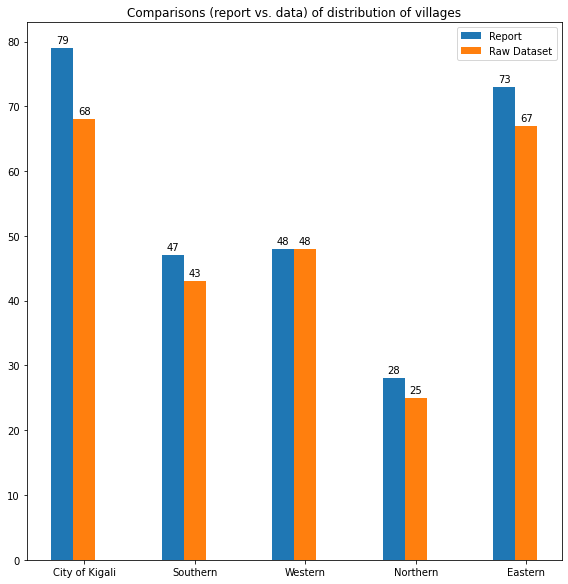

In [9]:
provinces = np.unique(main['Province'])
districts = np.unique(main['District'])
villages = np.unique(main['Village'])

# from the report
report_df = pd.DataFrame.from_dict(
    {
        'Province':["City of Kigali","Southern","Western","Northern","Eastern"],
        'Villages':[79,47,48,28,73],
        'Households':[948,564,576,336,876], 
    })

n_villages = []
n_hh = []
for p in report_df['Province']:
    df_p = main.loc[main['Province']==p]
    villages = np.unique(df_p['Village'])
    n_villages.append(len(villages))
    n_hh.append(len(df_p))
    
real_df = pd.DataFrame.from_dict(
    {
        'Province':["City of Kigali","Southern","Western","Northern","Eastern"],
        'Villages': n_villages,
        'Households': n_hh, 
    })  
    
bars_data = [
    {'label': "Report",'data': report_df['Villages']},
    {'label': "Raw Dataset",'data': real_df['Villages']}]

plot_bars(x_labels=real_df['Province'],bars_data=bars_data,length=8,height=8,add_autolabel=True,percent=False,
         title="Comparisons (report vs. data) of distribution of villages")


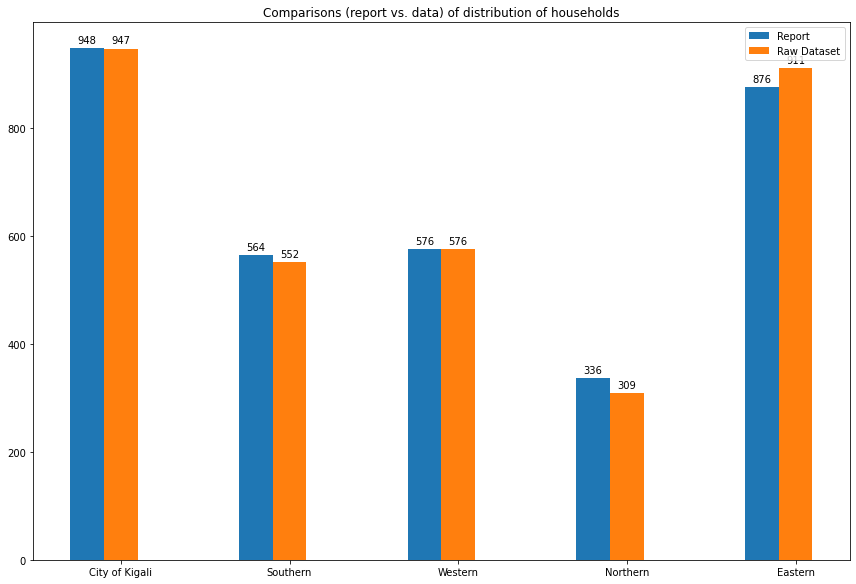

In [10]:
bars_data = [
    {'label': "Report",'data': report_df['Households']
    },
    {'label': "Raw Dataset",'data': real_df['Households']}
]


plot_bars(x_labels=real_df['Province'],bars_data=bars_data,length=12,height=8,add_autolabel=True,percent=False,
         title="Comparisons (report vs. data) of distribution of households")


## Type of habitat

There are two questions related to the habitat in the main dataset:
- **B5**: "What is the type of habitat?". Answers 1-3 are considered **rural**, answers 4-6 are considered **urban**. The answers of this question are presented in the screenshot bellow.

- Question **6** of the household identification section. However, the questionnaire has 2 options (urban, rural), while the dataset contains up to 6 possible answers. Moreover, in the provided dataset there are more than 2100 households (almost 65%) marked as "1" (urban). This does not seem realistic.

For the above considerations, we use question **B5** to divide between rural and urban households.
We add a column to the dataset corresponding to each household.

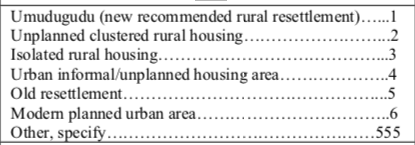

In [11]:
# Here is a screenshot of the questionnaire. 
Image("../images/rural_urban.png")

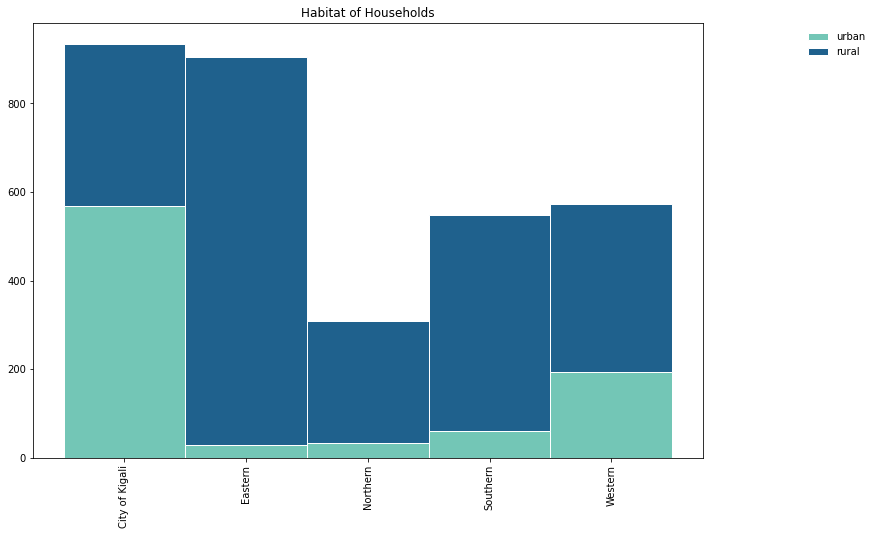

In [12]:
# We add a new column to the main dataset, with values 'urban','rural', or 'other'
# First option habitat_question = "B5_What is the type of habitat"
habitat_question = "B5_What is the type of habitat"

habitat = []
for index,row in main.iterrows():
    if row[habitat_question]==4 or row[habitat_question]==5 or row[habitat_question]==6:
        habitat.append('urban')
    elif row[habitat_question]==1 or row[habitat_question]==2 or row[habitat_question]==3:
        habitat.append('rural')
    else:
        habitat.append('other')
        
main['habitat'] = habitat

habitat_labels = ["urban","rural"]
data = get_bar_chart_data(main,provinces,"Province",habitat_labels,"habitat")
data["title"]="Habitat of Households"
stacked_bar_chart(data,color_scheme=COLOR_SCHEME,barWidth=1,
                  figure_name=None,
                      with_legend=True,title=True,
                      horizontal=False,
                      filename_legend=None,
                      length=12,height=8) 